# Walmart Market Basket Analysis

### Attribute Information:

* TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.


* VisitNumber - an id corresponding to a single trip by a single customer


* Weekday - the weekday of the trip


* Upc - the UPC number of the product purchased


* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.


* DepartmentDescription - a high-level description of the item's department


* FinelineNumber - a more refined category for each of the products, created by Walmart


# Import Libraries 

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


# Load the Dataset 

In [2]:
walmart = pd.read_csv("train_walmart.csv")

In [3]:
# Display the data
walmart.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [4]:
#Shape of the data
walmart.shape

(647054, 7)

In [5]:
#Check the datatypes
walmart.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

## Handling Missing values


In [6]:
#Check for missing values
print('Number of missing values across columns: \n', walmart.isnull().sum())

Number of missing values across columns: 
 TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64


<Figure size 864x432 with 0 Axes>

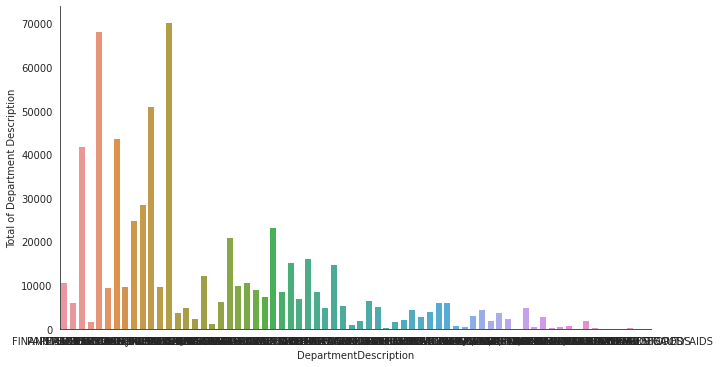

In [7]:
# Check the distribution of the rating
fig = plt.figure(figsize=(12,6))
with sns.axes_style('white'):
    g = sns.factorplot('DepartmentDescription', data=walmart, aspect=2.0,kind='count')
    g.set_ylabels("Total of Department Description");

In [8]:
walmart['Weekday'].unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

In [9]:
walmart['DepartmentDescription'].unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP', nan,
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',

In [10]:
walmart['TripType'].unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12],
      dtype=int64)

**The item that has been purchase and return in the same visit should be cut**

In [11]:
walmart.loc[walmart.duplicated(subset=['TripType', 'VisitNumber', 'Weekday', 'Upc', 'DepartmentDescription', 'FinelineNumber'], keep=False)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0
11,26,8,Friday,8.867930e+10,2,PAINT AND ACCESSORIES,3504.0
14,26,8,Friday,8.867930e+10,-1,PAINT AND ACCESSORIES,3504.0
15,26,8,Friday,2.238400e+09,2,PAINT AND ACCESSORIES,3565.0
55,42,19,Friday,7.675336e+09,1,IMPULSE MERCHANDISE,8904.0
...,...,...,...,...,...,...,...
646845,40,191298,Sunday,6.811310e+10,1,BEAUTY,4541.0
646984,38,191337,Sunday,2.259120e+10,1,MEAT - FRESH & FROZEN,1301.0
646985,38,191337,Sunday,2.259120e+10,-1,MEAT - FRESH & FROZEN,1301.0
647004,38,191337,Sunday,2.261680e+10,-1,MEAT - FRESH & FROZEN,6405.0


In [12]:
walmart = walmart.groupby(['Upc', 'TripType', 'VisitNumber', 'Weekday',
            'DepartmentDescription', 'FinelineNumber'])['ScanCount'].sum().reset_index()
walmart.head(3)

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount
0,834.0,39,134005,Friday,BAKERY,5016.0,1
1,834.0,39,187105,Sunday,BAKERY,5016.0,2
2,834.0,40,127954,Thursday,BAKERY,5016.0,3


In [13]:
walmart.loc[walmart.duplicated(subset=['TripType', 'VisitNumber', 'Weekday',
                             'Upc', 'DepartmentDescription', 'FinelineNumber'], keep=False)]

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount


In [14]:
walmart = walmart.loc[walmart['ScanCount'] != 0]

Ref: https://www.kaggle.com/xvivancos/market-basket-analysis/comments 

# Analyzing ScanCount

In [15]:
no_of_scanCount_per_visitNumber = walmart.groupby(by='VisitNumber')['ScanCount'].sum().sort_values(ascending=False)

no_of_scanCount_per_visitNumber.head()

VisitNumber
72439     311
88011     183
9181      137
178154    133
142397    132
Name: ScanCount, dtype: int64

In [16]:
#VisitNumber - an id corresponding to a single trip by a single customer
wVisit = walmart.loc[walmart['VisitNumber'] == 72439]
wVisit

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount
33608,1.089259e+09,24,72439,Tuesday,BATH AND SHOWER,2025.0,1
33612,1.089259e+09,24,72439,Tuesday,BATH AND SHOWER,2025.0,1
33650,1.089262e+09,24,72439,Tuesday,BATH AND SHOWER,2025.0,1
35458,1.111126e+09,24,72439,Tuesday,PERSONAL CARE,3165.0,2
36662,1.111177e+09,24,72439,Tuesday,PERSONAL CARE,3166.0,2
...,...,...,...,...,...,...,...
626673,8.806345e+11,24,72439,Tuesday,INFANT APPAREL,6901.0,1
627245,8.901100e+11,24,72439,Tuesday,INFANT APPAREL,6643.0,1
627863,8.961101e+11,24,72439,Tuesday,BOYS WEAR,4648.0,1
627881,8.961101e+11,24,72439,Tuesday,BOYS WEAR,4648.0,1


In [17]:
walmart_df = walmart.copy()

In [18]:
walmart_df.drop(columns=['TripType', 'Weekday','Upc','ScanCount','FinelineNumber'], axis=1, inplace=True)
walmart_df

,VisitNumber,DepartmentDescription
0,134005,BAKERY
1,187105,BAKERY
2,127954,BAKERY
4,26812,PRODUCE
5,136766,PRODUCE
...,...,...
628478,48766,BOOKS AND MAGAZINES
628479,92856,BOOKS AND MAGAZINES
628480,162950,BOOKS AND MAGAZINES
628481,97026,BOOKS AND MAGAZINES


### First alternative

In [19]:
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

In [20]:
# get all the transcactions as a list
transcactions = list(walmart_df['DepartmentDescription'])
# instantiate transcation encoder
encoder = TransactionEncoder().fit(transcactions)
onehot = encoder.transform(transcactions)
# convert one-hot encode data to DataFrame
onehot = pd.DataFrame(onehot, columns=encoder.columns_)
# compute frequent items using the Apriori algorithm - Get up to two items
frequent_itemsets = apriori(onehot, min_support = 0.00001, max_len =2, use_colnames=True)
# compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [21]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs items


### Second alternative

In [22]:
onehot = walmart_df.pivot_table(index='VisitNumber', columns='DepartmentDescription', aggfunc=len, fill_value=0)
onehot = onehot>0

In [23]:
# compute frequent items using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.000001, max_len=2, use_colnames=True)
# compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(HEALTH AND BEAUTY AIDS),(BEAUTY),0.000021,0.089078,0.000021,1.000000,11.226079,0.000020,inf
1,(LARGE HOUSEHOLD GOODS),(IMPULSE MERCHANDISE),0.000827,0.206958,0.000816,0.987013,4.769138,0.000645,61.064206


In [24]:
rules[rules.antecedents.apply(str).str.contains('LARGE HOUSEHOLD GOODS')].sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(LARGE HOUSEHOLD GOODS),(IMPULSE MERCHANDISE),0.000827,0.206958,0.000816,0.987013,4.769138,0.000645,61.064206


In [25]:
rules.sort_values('lift', ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(HEALTH AND BEAUTY AIDS),(BEAUTY),0.000021,0.089078,0.000021,1.000000,11.226079,0.000020,inf
1,(LARGE HOUSEHOLD GOODS),(IMPULSE MERCHANDISE),0.000827,0.206958,0.000816,0.987013,4.769138,0.000645,61.064206


## Third alternative

In [26]:
walmart.head(2)

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount
0,834.0,39,134005,Friday,BAKERY,5016.0,1
1,834.0,39,187105,Sunday,BAKERY,5016.0,2


In [27]:
temp = walmart.copy()

In [28]:
#Creating sparse matrix 
basket = (temp.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount']
          .sum().unstack().reset_index().fillna(0)
          .set_index('VisitNumber'))

#Eoding the quantity urchased
def encode(x):
    '''Encoding the scancount with 0s and 1s
    0:when qty is less than or equal to 0
    1:when qty is greater than or equal to 1'''
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
#Appying on our data
basket_sets = basket.applymap(encode)
basket_sets

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
191345,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Applying Apriori

In [29]:
#Apriori- Support70%
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

#Associaton rules-using lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.tail()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
33,"(GROCERY DRY GOODS, PRODUCE)",(DSD GROCERY),0.108573,0.315284,0.075434,0.694780,2.203660,0.041203,2.243348
34,"(DSD GROCERY, PRODUCE)",(GROCERY DRY GOODS),0.110945,0.228697,0.075434,0.679923,2.973034,0.050061,2.409740
35,(GROCERY DRY GOODS),"(DSD GROCERY, PRODUCE)",0.228697,0.110945,0.075434,0.329844,2.973034,0.050061,1.326639
36,(DSD GROCERY),"(GROCERY DRY GOODS, PRODUCE)",0.315284,0.108573,0.075434,0.239258,2.203660,0.041203,1.171786
37,(PRODUCE),"(GROCERY DRY GOODS, DSD GROCERY)",0.199626,0.138781,0.075434,0.377877,2.722830,0.047730,1.384323


### Create a function to customize rules

In [30]:
#Customizable function to change the lift and confidence
def rules_mod(lift,confidence):
    '''rules_mod is a function to control the rules 
    based on lift and confidence threshold'''
    return rules[ (rules['lift'] >= lift) &
      (rules['confidence'] >= confidence) ]

#Calling function
rules_mod(0.5,0.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DSD GROCERY),(COMM BREAD),0.315284,0.106812,0.071559,0.226966,2.124906,0.037883,1.155432
1,(COMM BREAD),(DSD GROCERY),0.106812,0.315284,0.071559,0.669950,2.124906,0.037883,2.074580
2,(GROCERY DRY GOODS),(COMM BREAD),0.228697,0.106812,0.073824,0.322803,3.022152,0.049396,1.318948
3,(COMM BREAD),(GROCERY DRY GOODS),0.106812,0.228697,0.073824,0.691156,3.022152,0.049396,2.497387
4,(DAIRY),(DSD GROCERY),0.191189,0.315284,0.119340,0.624200,1.979800,0.059061,1.822021
5,(DSD GROCERY),(DAIRY),0.315284,0.191189,0.119340,0.378515,1.979800,0.059061,1.301418
6,(GROCERY DRY GOODS),(DAIRY),0.228697,0.191189,0.118954,0.520137,2.720542,0.075229,1.685505
7,(DAIRY),(GROCERY DRY GOODS),0.191189,0.228697,0.118954,0.622179,2.720542,0.075229,2.041450
8,(DAIRY),(PRODUCE),0.191189,0.199626,0.096142,0.502864,2.519023,0.057976,1.609968
9,(PRODUCE),(DAIRY),0.199626,0.191189,0.096142,0.481609,2.519023,0.057976,1.560234


### Visualizing the results
The results in tabular form will not convey much insights into our algorithm so let's visualize the rules andd found the relationship between the metrics.

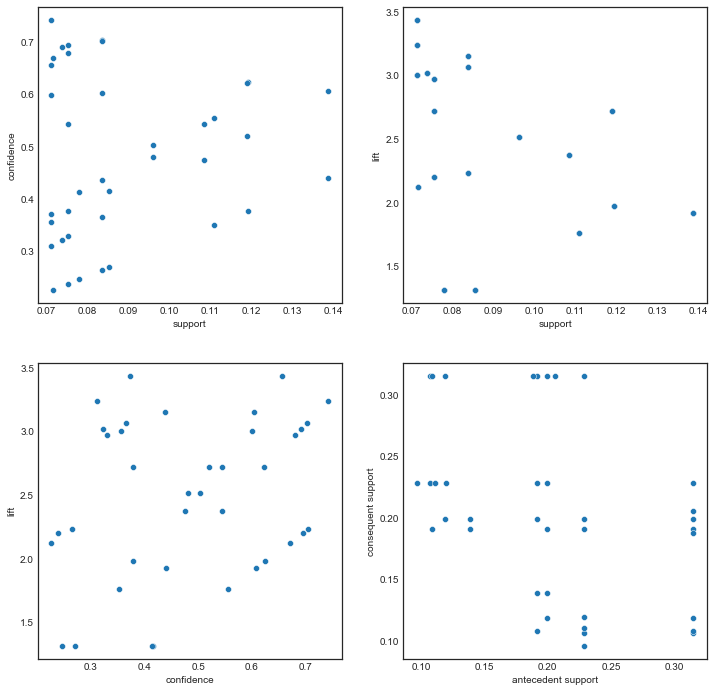

In [31]:
#Setting up the style
plt.figure(figsize = (12, 12))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules)
plt.subplot(222)
sns.scatterplot(x="support", y="lift",data=rules)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift",data=rules)
plt.subplot(224)
sns.scatterplot(x="antecedent support", y="consequent support",data=rules);

ValueError: Received invalid argument(s): edge_labels

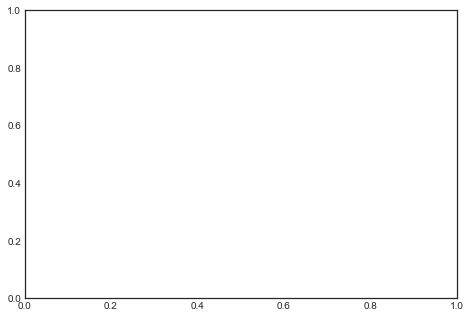

In [32]:
def draw_graph(rules, rules_to_show):

    import networkx as nx  
    G1 = nx.DiGraph()
   
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
     
        for a in rules.iloc[i]['antecedents']:
                
            G1.add_nodes_from([a])
        
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
        for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([a])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
                color_map.append('yellow')
        else:
            color_map.append('orange')       
 
 
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edge_labels=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
    for p in pos:  # raise text positions
           pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()
    #Calling function with 10 rulesabs
draw_graph(rules, 12)

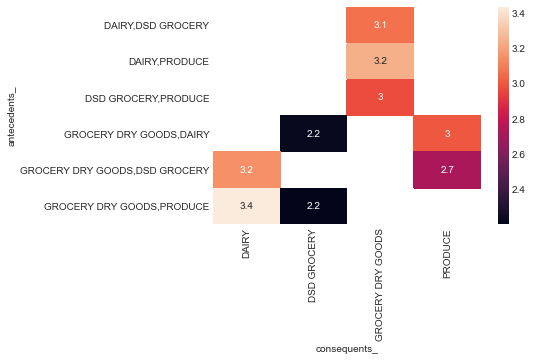

In [33]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>3].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>2].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1.5].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show();

## Insigths
We have found strong relationship between DSD GROCERY and DAIRY/GROCECRY DRY GOODS

#############################################################################################################################

# Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.



In [34]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=walmart.groupby("VisitNumber").filter(lambda x:x['ScanCount'].count() >0)

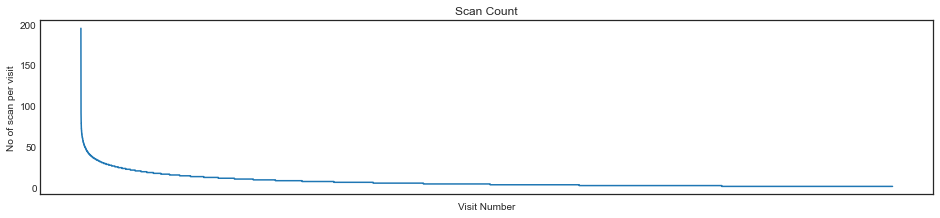

In [35]:
number_of_scanCount = new_df.groupby(by='VisitNumber')['ScanCount'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.2))
ax = plt.gca()
plt.plot(number_of_scanCount.values)
plt.title('Scan Count')
plt.xlabel('Visit Number')
plt.ylabel('No of scan per visit')
ax.set_xticklabels([])

plt.show();

In [36]:
#Average rating of the product 

new_df.groupby('VisitNumber')['ScanCount'].mean().head()

VisitNumber
5    -1.00
7     1.00
8     1.35
9     1.00
10    1.00
Name: ScanCount, dtype: float64

In [37]:
new_df.groupby('VisitNumber')['ScanCount'].mean().sort_values(ascending=False).head()


VisitNumber
7379      30.0
95785     24.0
142079    24.0
152742    20.0
158221    20.0
Name: ScanCount, dtype: float64

In [38]:
#Total no of rating for product

new_df.groupby('VisitNumber')['ScanCount'].count().sort_values(ascending=False).head()

VisitNumber
72439    195
88011    150
9181     113
60971    112
65792    109
Name: ScanCount, dtype: int64

In [39]:
scan_mean_count = pd.DataFrame(new_df.groupby('VisitNumber')['ScanCount'].mean())


In [40]:
scan_mean_count['scan_counts'] = pd.DataFrame(new_df.groupby('VisitNumber')['ScanCount'].count())


In [41]:
scan_mean_count.head()


,ScanCount,scan_counts
VisitNumber,,
5,-1.00,1
7,1.00,2
8,1.35,20
9,1.00,3
10,1.00,3


In [42]:
scan_mean_count['scan_counts'].max()

195

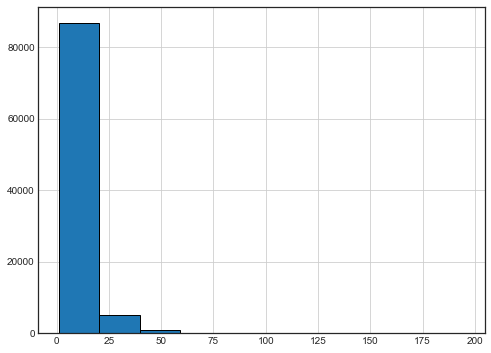

In [43]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
scan_mean_count['scan_counts'].hist(bins=10);

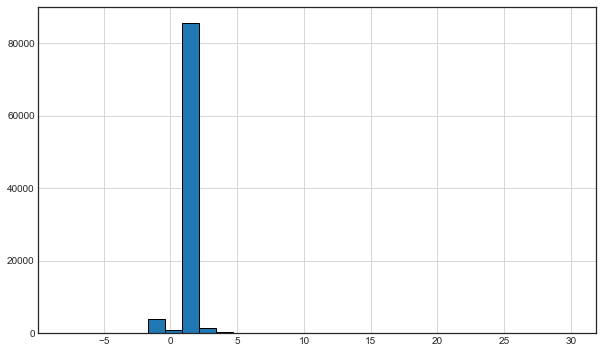

In [44]:
plt.figure(figsize=(10,6))
plt.rcParams['patch.force_edgecolor'] = True
scan_mean_count['ScanCount'].hist(bins=30);

<Figure size 864x576 with 0 Axes>

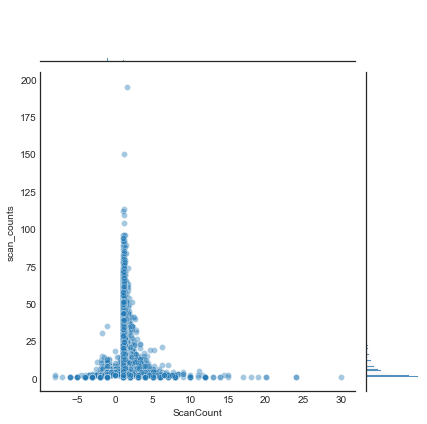

In [45]:
plt.figure(figsize=(12,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='ScanCount', y='scan_counts', data=scan_mean_count, alpha=0.4);

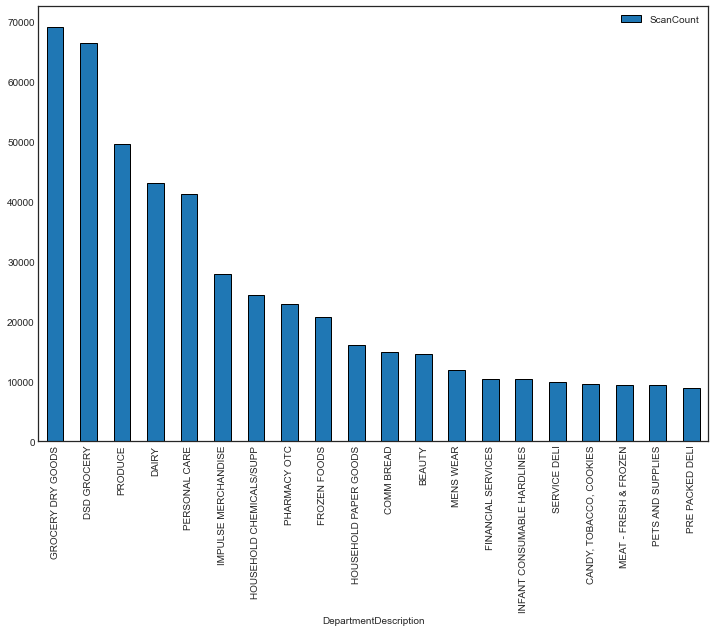

In [46]:
popular_products = pd.DataFrame(new_df.groupby('DepartmentDescription')['ScanCount'].count())
most_popular = popular_products.sort_values('ScanCount', ascending=False)
most_popular.head(20).plot(kind = "bar", figsize=(12,8));

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [47]:
walmart.head(2)

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount
0,834.0,39,134005,Friday,BAKERY,5016.0,1
1,834.0,39,187105,Sunday,BAKERY,5016.0,2


In [48]:
#new_df = walmart.head(10000)
#ratings_matrix = walmart.pivot_table(values='ScanCount', index='VisitNumber', columns='VisitNumber')
#ratings_matrix.head()

As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [ ]:
ratings_matrix.shape

Transposing the matrix

In [ ]:
X = ratings_matrix.T
X.head()

In [ ]:
X.shape


Unique products in subset of data


In [ ]:
X1 = X


In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

In [ ]:
X.index[75]


Index # of product ID purchased by customer



In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

Recommending top 25 highly correlated products in sequence



In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.
